# Marco Lavorini   -  Assignment 3

In [107]:
import idx2numpy
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from tqdm import tqdm



def read_idx(filename):
    array = idx2numpy.convert_from_file(filename)
    return array

files = ["train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte"]

print(os.path.join("..", "datasets", "mnist", files[0]))
x_train = read_idx(os.path.join("..", "datasets", "mnist", files[0]))
y_train = read_idx(os.path.join("..", "datasets", "mnist", files[1]))
x_test = read_idx(os.path.join("..", "datasets", "mnist", files[2]))
y_test = read_idx(os.path.join("..", "datasets", "mnist", files[3]))

print(y_train)





../datasets/mnist/train-images.idx3-ubyte
[5 0 4 ... 5 6 8]


In [108]:
x_train_b = np.where(x_train > 0, 1, 0)
x_test_b = np.where(x_test > 0, 1, 0)

x_train_b = x_train/255
x_test_b = x_test/255

x_test_flatten = x_test_b.reshape(x_test_b.shape[0], -1)
x_test_flatten.shape



(10000, 784)

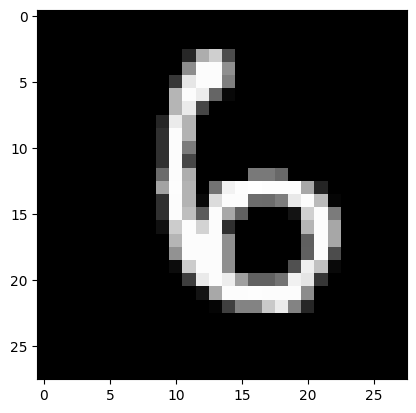

In [109]:
#print first element in data using matplot lib
plt.imshow(x_train_b[186], cmap='gray')
plt.show()

# Sigmoid function

In [110]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [111]:
def mse(net):   
    metric = []
    for i in range(len(x_test_b[0:3000])):
        img = i
        original = x_test_flatten[img]
        recon = net.reconstruct(original).T
        metric.append(mean_squared_error(original, recon))
    return np.mean(metric)


In [112]:

class rbm:
    def __init__(self, num_visible, num_hidden):
        self.h = num_hidden
        self.v = num_visible
        self.W = np.random.uniform(-0.05, 0.05, (num_visible, num_hidden))
        self.bh = np.zeros(num_hidden)
        self.bv = np.zeros(num_visible)
    
    def fit(self, X, epochs=10, lr=0.01, batch_size=10):
        print("todo")
        metric = []

        for epoch in tqdm(range(epochs)):
            err=[]
            for data in X:
                # wake part
                #print('wake')
                pos_def_P = sigmoid(np.dot(data.T, self.W) + self.bh)

                #print(f'pos_def_P shape: {pos_def_P.shape}')
                #print(f'max pos_def_P: {np.max(pos_def_P)}')
                #print(f'max X: {np.max(data)}')
                
                wake = np.dot(data, pos_def_P)
                #print(wake)
                #print(f'\n\n(max wake: {np.max(wake)}\n\n')
            
                #print('dream')
                # dream part
                pos_hid_S = pos_def_P > np.random.rand(self.h) # stochastic hidden activation
                recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

                recon_data = recon_data_P > np.random.rand(self.v)
                neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
                dream = np.dot(recon_data.T, neg_hid_P)
                #print(dream)
                #check
                #err.append(np.sum(data - recon_data)**2)   #check  
            

                deltaW = (wake - dream)
                deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))
                deltaBv = (np.sum(data) - np.sum(recon_data))
                self.W += lr * deltaW
                self.bh += lr * deltaBh
                self.bv += lr * deltaBv
            #print(f'epoch: {epoch}, err: {np.mean(err)}, len err: {len(err)}')
            metric.append(mse(self))
                

    
    def fit_batch(self, data, epochs=10, lr=0.01, batch_size=10):
        print("todo")
        metric = []
        iter = len(data)/batch_size
        print(iter)
        for epoch in tqdm(range(epochs)):
            for i in range(int(iter)):
                X = data[i*batch_size:i*batch_size+ batch_size]
                # wake part
                #print('wake')
                pos_def_P = sigmoid(np.dot(X, self.W) + self.bh)

                #print(f'pos_def_P shape: {pos_def_P.shape}')
                #print(f'max pos_def_P: {np.max(pos_def_P)}')
                #print(f'max X: {np.max(data)}')
                
                wake = np.dot(X.T, pos_def_P)
                #print(wake)
                #print(f'\n\n(max wake: {np.max(wake)}\n\n')
        
                #print('dream')
                # dream part
                pos_hid_S = pos_def_P > np.random.rand(len(pos_def_P), len(pos_def_P[0])) # stochastic hidden activation
                recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

                recon_data = recon_data_P > np.random.rand(len(recon_data_P), len(recon_data_P[0]))
                neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
                dream = np.dot(recon_data.T, neg_hid_P)
                #print(dream)

                #err = (np.sum(X - recon_data)**2)/len(X)   #check  
        

                deltaW = (wake - dream)/len(X)
                deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))/len(X)
                deltaBv = (np.sum(X) - np.sum(recon_data))/len(X)
                self.W += lr * deltaW
                self.bh += lr * deltaBh
                self.bv += lr * deltaBv
        #print(f'epoch: {epoch}, err: {np.mean(err)}, len err: {len(err)}')
            metric.append(mse(self))
        return metric

    def reconstruct(self, X):
        hidden = sigmoid(np.dot(X.T, self.W) + self.bh)
        reconstructed = sigmoid(np.dot(hidden, self.W.T) + self.bv)
        return reconstructed

# valutare di samplare su distribuzioni gausssiane per vl aleatoria non binaria 

# valutare cd_k

In [113]:
print(x_train.shape)
print(x_train[0].shape)
print(x_train[0].flatten().shape)

(60000, 28, 28)
(28, 28)
(784,)


In [114]:

x_train_flattened = x_train_b.reshape(x_train_b.shape[0], -1, 1)
print(x_train_flattened.shape)
print(y_train.shape)

(60000, 784, 1)
(60000,)


In [115]:
net = rbm(x_train_flattened.shape[1], 512)
print(f'v = {net.v}')
print(f'h = {net.h}')

v = 784
h = 512


In [16]:
net.fit(x_train_flattened[:1000], epochs=30, lr=0.01, batch_size=500)

todo


100%|██████████| 30/30 [06:31<00:00, 13.05s/it]


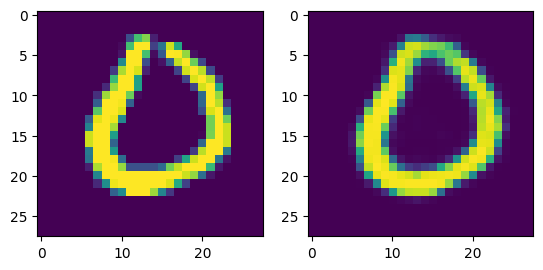

In [129]:
recon = net.reconstruct(x_train_flattened[4])
img = 2500

recon = net.reconstruct(x_train_flattened[img])
#plot the original by the side
plt.subplot(1, 2, 1)
plt.imshow(x_train[img].reshape(28, 28))
plt.subplot(1, 2, 2)
plt.imshow(recon.reshape(28, 28))

plt.show()

In [116]:
net = rbm(x_train_flattened.shape[1], 512)
print(f'v = {net.v}')
print(f'h = {net.h}')

v = 784
h = 512


In [117]:
x_train_b.shape
x_train_flattened_batch = x_train_b.reshape(x_train_b.shape[0], -1)

In [118]:
losses = net.fit_batch(x_train_flattened_batch[:4000], epochs=100, lr=0.01, batch_size=10)

todo
400.0


100%|██████████| 100/100 [16:24<00:00,  9.85s/it]


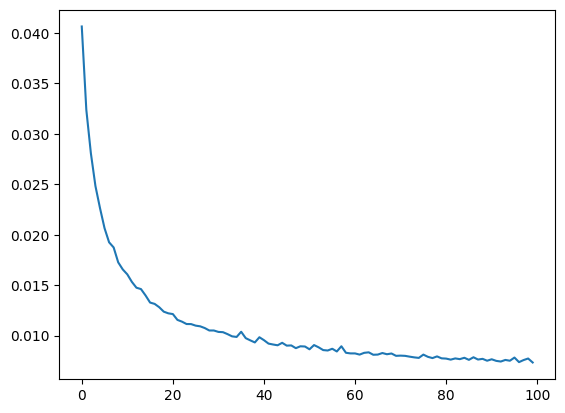

In [119]:
# plot the losses
plt.plot(losses)
plt.show()

(784,)
0.4997775281812621


(1, 784)

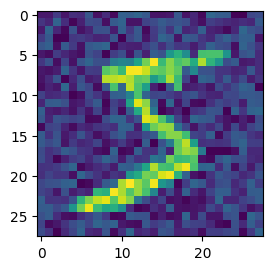

In [63]:

#img = 16999

original = x_train_flattened[img]
plt.subplot(1, 2, 1)
plt.imshow(original.reshape(28, 28))

# apply random noise to the image
noise = np.random.rand(784)/2
print(noise.shape)
print(np.max(noise))
noisy = original.T + noise

plt.subplot(1, 2, 1)
plt.imshow(noisy.reshape(28, 28))

noisy.shape



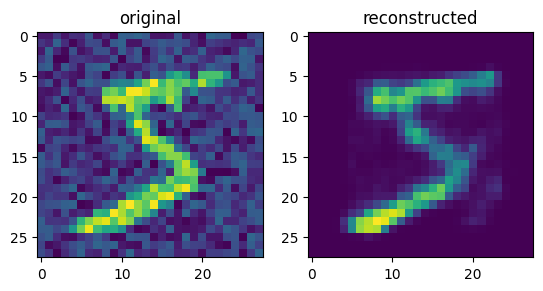

In [64]:

#img = 16999
original = x_train_flattened[img]
recon = net.reconstruct(noisy.T)
#plot the original by the side
plt.subplot(1, 2, 1)
plt.imshow(noisy.reshape(28, 28))
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(recon.reshape(28, 28))
plt.title('reconstructed')

plt.show()

In [65]:
(recon - original.T).shape

(1, 784)

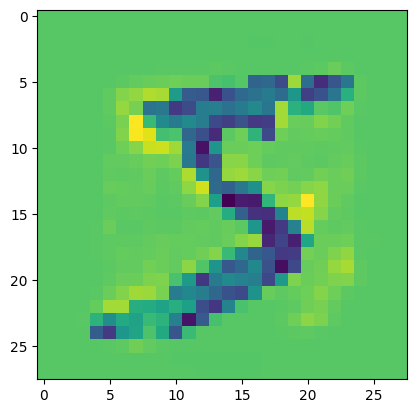

4.76691358078872

In [69]:
test = (recon - original.T).reshape(28, 28)
# print the image with matplotlib
plt.imshow(test)
plt.show()
# calculate the norm of test
np.linalg.norm(test)

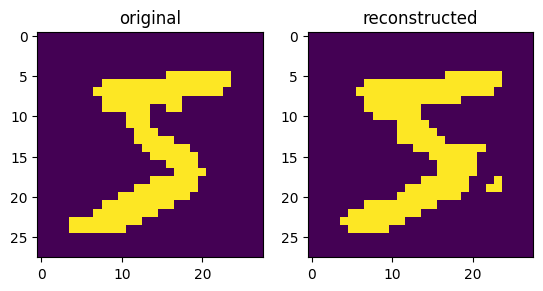

In [70]:
# threshold the image, 0 if equals to 0 1 otherwhise
original_t = np.where(original > 0.09, 1, 0)
recon_t = np.where(recon > 0.09, 1, 0)
# print the image with matplotlib
plt.subplot(1, 2, 1)
plt.imshow(original_t.reshape(28, 28))
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(recon_t.reshape(28, 28))
plt.title('reconstructed')

plt.show()


In [72]:
print(original_t.shape, recon_t.shape)

(784, 1) (1, 784)


In [73]:
# calculate jaccard similarity
from sklearn.metrics import jaccard_score
jaccard_score(original_t, recon_t.T)


0.8023255813953488

In [86]:
metric = []
for i in tqdm(range(len(x_test_b[0:3000]))):
    img = i
    original = x_test_flatten[img]
    recon = net.reconstruct(original).T
    metric.append(mean_squared_error(original, recon))

"""
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(28, 28))
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(recon.reshape(28, 28))
    plt.title('reconstructed')
    metric.append(mean_squared_error(original, recon))"""

np.mean(metric)


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:03<00:00, 955.37it/s] 


0.006853316840794481

In [82]:
np.max(metric)
np.min(metric)

0.0006785194779511546

In [83]:
mean_squared_error(original, recon)

0.010055808711170781